# 📊 모델 비교 테스트

여러 실험 모델들을 동일한 테스트 문장으로 평가하고 비교합니다.

**평가 대상 모델:**
- Baseline: 기본 KcELECTRA 학습 모델
- E1: Threshold 튜닝 모델
- E2: Precision 메트릭 최적화 모델
- E4: 데이터 증강 모델 (LOL 욕설 + 특수문자 정상)
- E5: E4 + 가중치 반영 (정상:악성 = 4:1)

In [45]:
# ========================================
# 📦 1) 라이브러리 임포트
# ========================================
import os
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print(f"PyTorch: {torch.__version__}")
print(f"GPU 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.7.1+cu118
GPU 사용 가능: True
GPU: NVIDIA GeForce RTX 4060 Ti


In [46]:
# ========================================
# 🔧 2) 모델 경로 설정
# ========================================
# 실험 완료 후 해당 모델 경로를 활성화하세요

MODEL_CONFIGS = {
    "Baseline": {
        "path": "../kcelectra_output/best_model",
        "threshold": 0.5,  # 기본 threshold
        "enabled": True,   # 이 모델을 평가할지 여부
    },
    "E1 (Threshold 튜닝)": {
        "path": "./E1_output/best_model",
        "threshold": 0.90,  # E1 실험에서 찾은 최적 threshold (FP 최소, Recall>=0.8)
        "enabled": True,
    },
    "E2 (Precision 최적화)": {
        "path": "./E2_output/best_model",
        "threshold": 0.5,
        "enabled": True,  # 실험 완료 후 True로 변경
    },
    "E3 (Loss Weight)": {
        "path": "./E3_output/best_model",
        "threshold": 0.5,
        "enabled": False,  # 실험 완료 후 True로 변경
    },
    "E4 (데이터 증강)": {
        "path": "./E4_output/best_model",
        "threshold": 0.5,
        "enabled": True,
    },
    "E5 (증강+가중치)": {
        "path": "./E5_output/best_model",
        "threshold": 0.5,
        "enabled": True,
    },
}

# 활성화된 모델만 필터링
ACTIVE_MODELS = {k: v for k, v in MODEL_CONFIGS.items() if v["enabled"]}

# 모델 존재 여부 확인
print("📋 평가 대상 모델:")
for name, config in ACTIVE_MODELS.items():
    exists = os.path.exists(config["path"])
    status = "✅ 존재" if exists else "❌ 없음"
    print(f"  - {name}: {status}")
    print(f"    경로: {config['path']}")
    print(f"    Threshold: {config['threshold']}")

📋 평가 대상 모델:
  - Baseline: ✅ 존재
    경로: ../kcelectra_output/best_model
    Threshold: 0.5
  - E1 (Threshold 튜닝): ✅ 존재
    경로: ./E1_output/best_model
    Threshold: 0.9
  - E2 (Precision 최적화): ✅ 존재
    경로: ./E2_output/best_model
    Threshold: 0.5
  - E4 (데이터 증강): ✅ 존재
    경로: ./E4_output/best_model
    Threshold: 0.5
  - E5 (증강+가중치): ❌ 없음
    경로: ./E5_output/best_model
    Threshold: 0.5


In [47]:
# ========================================
# 📋 3) 테스트 데이터셋 정의
# ========================================

test_data = [
    # 정상 - 일반 문장
    {"text": "친절하게 도와주셔서 감사합니다.", "label": 0, "category": "정상-일반"},
    {"text": "뭐라는거야 진짜 짜증나게", "label": 0, "category": "정상-일반"},
    {"text": "아름다운 밤이네요.", "label": 0, "category": "정상-일반"},
    {"text": "아하! 컴마를 빼먹다니 정신나갔군", "label": 0, "category": "정상-일반"},
    {"text": "비꼬지마셈 발작자제좀", "label": 0, "category": "정상-일반"},

    # 정상 - 초성/변형 (하드 네거티브)
    {"text": "아니 그게아니라니까요 ㅈㅂ 믿어줘 ㄹㅇ로 구라아님", "label": 0, "category": "정상-하드네거티브"},
    {"text": "ㅋㅋㅎㅇ", "label": 0, "category": "정상-하드네거티브"},
    {"text": "나 노래방 18번 업슴", "label": 0, "category": "정상-하드네거티브"},
    {"text": "쌈@뽕하구만", "label": 0, "category": "정상-하드네거티브"},

    # 정상 - 모델 하드카운터 (특수문자/짧은 문장)
    {"text": "@", "label": 0, "category": "정상-하드카운터"},
    {"text": "개발자", "label": 0, "category": "정상-하드카운터"},
    {"text": "개새우튀김", "label": 0, "category": "정상-하드카운터"},
    {"text": "물방개새우티김", "label": 0, "category": "정상-하드카운터"},
    {"text": "대 상 혁", "label": 0, "category": "정상-하드카운터"},
    {"text": "^0^", "label": 0, "category": "정상-하드카운터"},

    # 악성 - 일반 욕설
    {"text": "야 이 개새끼야", "label": 1, "category": "악성-일반욕설"},
    {"text": "시발 개쳐웃기네 ㅋㅋㅋㅋㅋ 그런 생각은 어떻게 하는거냐?", "label": 1, "category": "악성-일반욕설"},
    {"text": "엥 좆됐네", "label": 1, "category": "악성-일반욕설"},
    {"text": "?? 병신이세요?", "label": 1, "category": "악성-일반욕설"},
    {"text": "미친년이.죽.고싶어서.환장을했다.", "label": 1, "category": "악성-일반욕설"},

    # 악성 - 변형 욕설
    {"text": "야 이 개새야", "label": 1, "category": "악성-변형욕설"},
    {"text": "야 이 개새새야", "label": 1, "category": "악성-변형욕설"},
    {"text": "그러게 하지 말랄 때 안 했으면 됐잖아 ㅆ댕", "label": 1, "category": "악성-변형욕설"},
    {"text": "ㅋㅋㅋㅋㅋ 아잇 ㅈ됐네", "label": 1, "category": "악성-변형욕설"},
    {"text": "18ㅋㅋ", "label": 1, "category": "악성-변형욕설"},
    {"text": "ㅇㅁ없는ㄴㅋㅋ 넌 나가라", "label": 1, "category": "악성-변형욕설"},
    {"text": "ㅈ1랄마쇼", "label": 1, "category": "악성-변형욕설"},
]

test_df = pd.DataFrame(test_data)
print(f"📊 테스트 데이터: {len(test_df)}개")
print(f"   정상: {sum(test_df['label']==0)}개, 악성: {sum(test_df['label']==1)}개")
print(f"\n📂 카테고리별 분포:")
print(test_df['category'].value_counts().to_string())

📊 테스트 데이터: 27개
   정상: 15개, 악성: 12개

📂 카테고리별 분포:
category
악성-변형욕설      7
정상-하드카운터     6
정상-일반        5
악성-일반욕설      5
정상-하드네거티브    4


In [48]:
# ========================================
# 🔍 4) 모델 로드 및 예측 함수
# ========================================

def load_model(model_path):
    """모델과 토크나이저를 로드합니다."""
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    return model, tokenizer, device


def predict(model, tokenizer, device, texts, threshold=0.5):
    """텍스트 리스트를 예측합니다."""
    enc = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    enc = {k: v.to(device) for k, v in enc.items()}
    
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = (probs >= threshold).astype(int)
    
    return preds, probs


def evaluate_model(model_name, config, test_df):
    """단일 모델을 평가하고 결과를 반환합니다."""
    if not os.path.exists(config["path"]):
        print(f"⚠️ {model_name}: 모델 경로가 존재하지 않습니다.")
        return None
    
    print(f"\n🔄 {model_name} 로딩 중...")
    model, tokenizer, device = load_model(config["path"])
    
    texts = test_df['text'].tolist()
    labels = test_df['label'].tolist()
    threshold = config["threshold"]
    
    preds, probs = predict(model, tokenizer, device, texts, threshold)
    
    # 메트릭 계산
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # GPU 메모리 정리
    del model
    torch.cuda.empty_cache()
    
    return {
        "model_name": model_name,
        "threshold": threshold,
        "preds": preds,
        "probs": probs,
        "cm": cm,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "fpr": fpr,
    }

print("✅ 함수 정의 완료")

✅ 함수 정의 완료


In [49]:
# ========================================
# 🚀 5) 모든 모델 평가 실행
# ========================================

results = {}

for model_name, config in ACTIVE_MODELS.items():
    result = evaluate_model(model_name, config, test_df)
    if result:
        results[model_name] = result
        print(f"✅ {model_name} 평가 완료")

print(f"\n📊 총 {len(results)}개 모델 평가 완료")


🔄 Baseline 로딩 중...
✅ Baseline 평가 완료

🔄 E1 (Threshold 튜닝) 로딩 중...
✅ E1 (Threshold 튜닝) 평가 완료

🔄 E2 (Precision 최적화) 로딩 중...
✅ E2 (Precision 최적화) 평가 완료

🔄 E4 (데이터 증강) 로딩 중...
✅ E4 (데이터 증강) 평가 완료
⚠️ E5 (증강+가중치): 모델 경로가 존재하지 않습니다.

📊 총 4개 모델 평가 완료


In [50]:
# ========================================
# 📊 6) 모델 비교 요약표
# ========================================

print("=" * 80)
print("📊 모델 비교 요약")
print("=" * 80)

summary_data = []
for name, r in results.items():
    summary_data.append({
        "모델": name,
        "Threshold": r["threshold"],
        "Accuracy": f"{r['accuracy']:.1%}",
        "Precision": f"{r['precision']:.1%}",
        "Recall": f"{r['recall']:.1%}",
        "F1": f"{r['f1']:.1%}",
        "FP(오탐)": r["fp"],
        "FN(미탐)": r["fn"],
        "FPR": f"{r['fpr']:.1%}",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

📊 모델 비교 요약
                모델  Threshold Accuracy Precision Recall    F1  FP(오탐)  FN(미탐)   FPR
          Baseline        0.5    48.1%     40.0%  33.3% 36.4%       6       8 40.0%
 E1 (Threshold 튜닝)        0.9    40.7%     16.7%   8.3% 11.1%       5      11 33.3%
E2 (Precision 최적화)        0.5    44.4%     33.3%  25.0% 28.6%       6       9 40.0%
       E4 (데이터 증강)        0.5    66.7%     63.6%  58.3% 60.9%       4       5 26.7%


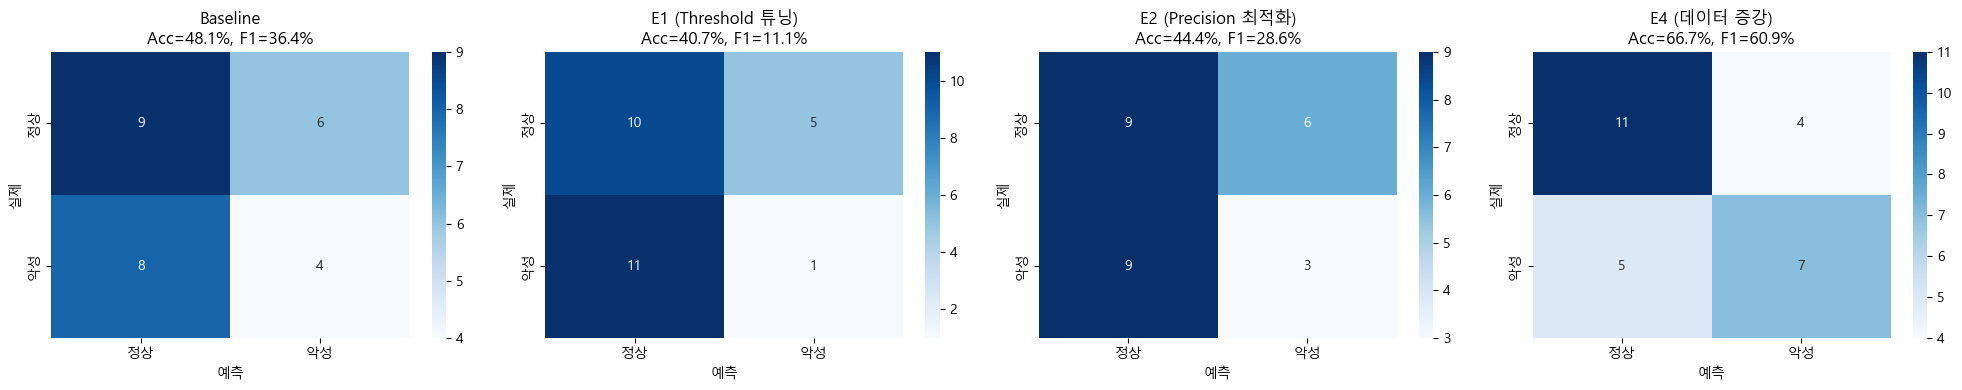

📁 저장됨: 모델비교_혼동행렬.png


In [51]:
# ========================================
# 📈 7) 혼동행렬 시각화 (모든 모델)
# ========================================

n_models = len(results)
if n_models > 0:
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (name, r) in zip(axes, results.items()):
        sns.heatmap(r["cm"], annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['정상', '악성'],
                    yticklabels=['정상', '악성'], ax=ax)
        ax.set_xlabel('예측')
        ax.set_ylabel('실제')
        ax.set_title(f'{name}\nAcc={r["accuracy"]:.1%}, F1={r["f1"]:.1%}')
    
    plt.tight_layout()
    plt.savefig('모델비교_혼동행렬.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("📁 저장됨: 모델비교_혼동행렬.png")

In [52]:
# ========================================
# 📊 8) 카테고리별 성능 비교
# ========================================

print("\n" + "=" * 80)
print("📊 카테고리별 정확도 비교")
print("=" * 80)

categories = test_df['category'].unique()

category_comparison = []
for category in categories:
    subset_idx = test_df[test_df['category'] == category].index
    row = {"카테고리": category, "총개수": len(subset_idx)}
    
    for model_name, r in results.items():
        correct = sum(test_df.loc[subset_idx, 'label'] == r['preds'][subset_idx])
        acc = correct / len(subset_idx) if len(subset_idx) > 0 else 0
        row[model_name] = f"{acc:.0%}"
    
    category_comparison.append(row)

category_df = pd.DataFrame(category_comparison)
print(category_df.to_string(index=False))


📊 카테고리별 정확도 비교
     카테고리  총개수 Baseline E1 (Threshold 튜닝) E2 (Precision 최적화) E4 (데이터 증강)
    정상-일반    5      80%              100%                80%         80%
정상-하드네거티브    4      75%               75%                75%         75%
 정상-하드카운터    6      33%               33%                33%         67%
  악성-일반욕설    5      40%                0%                40%         80%
  악성-변형욕설    7      29%               14%                14%         43%


In [53]:
# ========================================
# 📝 9) 개별 예측 결과 비교 (틀린 것 분석)
# ========================================

print("\n" + "=" * 80)
print("📝 모델별 예측 비교 (오답 분석)")
print("=" * 80)

# 각 문장에 대해 모델별 예측 추가
comparison_df = test_df.copy()
for model_name, r in results.items():
    comparison_df[f"{model_name}_pred"] = r['preds']
    comparison_df[f"{model_name}_prob"] = r['probs']

# 적어도 하나의 모델이 틀린 케이스만 출력
print("\n🔍 오답 케이스 상세 분석:")
print("-" * 80)

for idx, row in comparison_df.iterrows():
    any_wrong = False
    for model_name in results.keys():
        if row['label'] != row[f"{model_name}_pred"]:
            any_wrong = True
            break
    
    if any_wrong:
        label_str = "악성" if row['label'] == 1 else "정상"
        print(f"\n[{row['category']}] {row['text']}")
        print(f"   정답: {label_str}")
        
        for model_name in results.keys():
            pred = row[f"{model_name}_pred"]
            prob = row[f"{model_name}_prob"]
            pred_str = "악성" if pred == 1 else "정상"
            is_correct = "✅" if row['label'] == pred else "❌"
            
            error_type = ""
            if row['label'] != pred:
                if row['label'] == 0 and pred == 1:
                    error_type = " (FP 오탐)"
                else:
                    error_type = " (FN 미탐)"
            
            print(f"   {is_correct} {model_name}: {pred_str} ({prob:.1%}){error_type}")


📝 모델별 예측 비교 (오답 분석)

🔍 오답 케이스 상세 분석:
--------------------------------------------------------------------------------

[정상-일반] 비꼬지마셈 발작자제좀
   정답: 정상
   ❌ Baseline: 악성 (64.5%) (FP 오탐)
   ✅ E1 (Threshold 튜닝): 정상 (64.5%)
   ❌ E2 (Precision 최적화): 악성 (82.0%) (FP 오탐)
   ❌ E4 (데이터 증강): 악성 (91.0%) (FP 오탐)

[정상-하드네거티브] 쌈@뽕하구만
   정답: 정상
   ❌ Baseline: 악성 (99.9%) (FP 오탐)
   ❌ E1 (Threshold 튜닝): 악성 (99.9%) (FP 오탐)
   ❌ E2 (Precision 최적화): 악성 (99.9%) (FP 오탐)
   ❌ E4 (데이터 증강): 악성 (100.0%) (FP 오탐)

[정상-하드카운터] @
   정답: 정상
   ❌ Baseline: 악성 (94.5%) (FP 오탐)
   ❌ E1 (Threshold 튜닝): 악성 (94.5%) (FP 오탐)
   ❌ E2 (Precision 최적화): 악성 (99.9%) (FP 오탐)
   ✅ E4 (데이터 증강): 정상 (0.1%)

[정상-하드카운터] 개새우튀김
   정답: 정상
   ❌ Baseline: 악성 (95.6%) (FP 오탐)
   ❌ E1 (Threshold 튜닝): 악성 (95.6%) (FP 오탐)
   ❌ E2 (Precision 최적화): 악성 (77.5%) (FP 오탐)
   ❌ E4 (데이터 증강): 악성 (51.6%) (FP 오탐)

[정상-하드카운터] 대 상 혁
   정답: 정상
   ❌ Baseline: 악성 (95.2%) (FP 오탐)
   ❌ E1 (Threshold 튜닝): 악성 (95.2%) (FP 오탐)
   ❌ E2 (Precision 최적화): 악성 (98.8%) (FP 오탐)
   

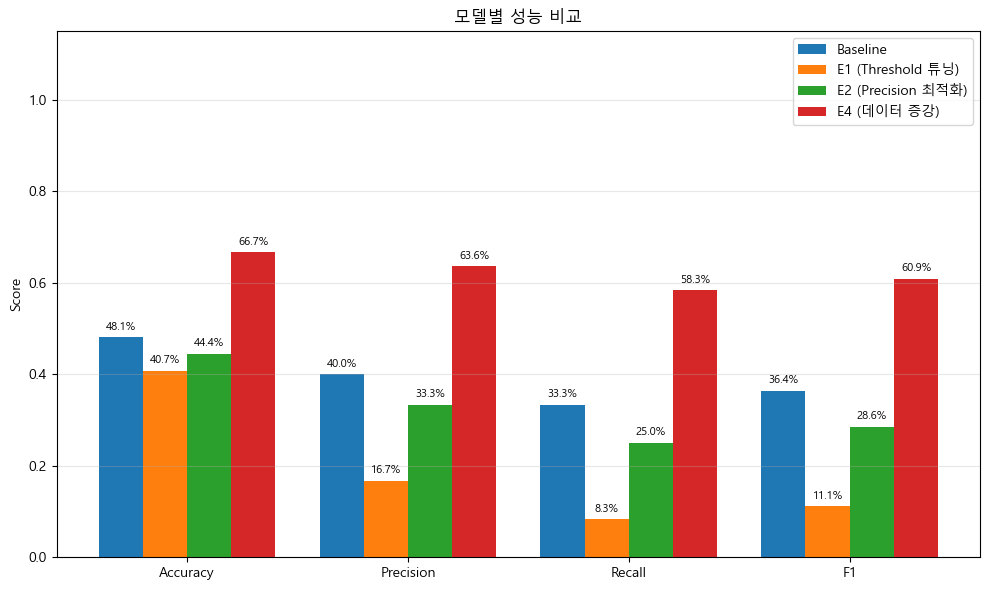

📁 저장됨: 모델비교_성능그래프.png


In [54]:
# ========================================
# 📈 10) 성능 지표 막대 그래프
# ========================================

if len(results) > 1:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(metrics))
    width = 0.8 / len(results)
    
    for i, (model_name, r) in enumerate(results.items()):
        values = [r[m] for m in metrics]
        bars = ax.bar(x + i * width, values, width, label=model_name)
        
        # 막대 위에 값 표시
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{val:.1%}', ha='center', va='bottom', fontsize=8)
    
    ax.set_ylabel('Score')
    ax.set_title('모델별 성능 비교')
    ax.set_xticks(x + width * (len(results) - 1) / 2)
    ax.set_xticklabels(metric_names)
    ax.legend()
    ax.set_ylim(0, 1.15)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('모델비교_성능그래프.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("📁 저장됨: 모델비교_성능그래프.png")

In [55]:
# ========================================
# 📋 11) README용 결과 요약 출력
# ========================================

print("\n" + "=" * 80)
print("📋 README.md용 마크다운 테이블 (복사용)")
print("=" * 80)

print("\n| 모델 | Threshold | Acc | Precision | Recall | F1 | FP | FN |")
print("|------|-----------|-----|-----------|--------|----|----|----|") 
for name, r in results.items():
    print(f"| {name} | {r['threshold']} | {r['accuracy']:.1%} | {r['precision']:.1%} | {r['recall']:.1%} | {r['f1']:.1%} | {r['fp']} | {r['fn']} |")


📋 README.md용 마크다운 테이블 (복사용)

| 모델 | Threshold | Acc | Precision | Recall | F1 | FP | FN |
|------|-----------|-----|-----------|--------|----|----|----|
| Baseline | 0.5 | 48.1% | 40.0% | 33.3% | 36.4% | 6 | 8 |
| E1 (Threshold 튜닝) | 0.9 | 40.7% | 16.7% | 8.3% | 11.1% | 5 | 11 |
| E2 (Precision 최적화) | 0.5 | 44.4% | 33.3% | 25.0% | 28.6% | 6 | 9 |
| E4 (데이터 증강) | 0.5 | 66.7% | 63.6% | 58.3% | 60.9% | 4 | 5 |
